### Time Series Analysis on Tea Production

#### Setting up the system

In [18]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [19]:
# importing the dataset

df = pd.read_csv('nvk_production.csv')
df.head()

,Date,GREEN LEAF (Kg),MADE TEA (Kg),NETT OUT TURN,NETT SALE AVERAGE (Rs),LOW GROWN AVERAGE (Rs),DIFFERENCE (Rs),BOUGHT LEAF RATE (Rs)
0,30-Apr-1997,417935,94143.0,22.53,145.17,120.31,24.86,20.76
1,31-May-1997,510033,109461.0,21.46,150.33,129.36,20.97,21.70
2,30-Jun-1997,436533,97275.0,22.28,160.32,135.69,24.63,23.10
3,31-Jul-1997,475422,98949.0,20.81,158.19,131.57,26.62,22.70
4,31-Aug-1997,441680,97419.0,22.06,161.18,138.90,22.28,23.50


#### Data Exploration

In [20]:
df.describe()

,GREEN LEAF (Kg),MADE TEA (Kg),NETT OUT TURN,NETT SALE AVERAGE (Rs),LOW GROWN AVERAGE (Rs),DIFFERENCE (Rs),BOUGHT LEAF RATE (Rs)
count,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,315.000000
mean,617772.202532,131543.454114,21.375538,481.917247,417.246835,64.670411,67.405111
std,124931.300808,24519.161723,0.784540,357.192608,308.193115,53.704538,49.662106
min,219222.000000,51224.000000,18.460000,145.170000,106.480000,14.570000,20.760000
25%,524681.500000,114618.375000,20.850000,204.255000,169.760000,30.412500,28.350000
50%,624874.500000,133316.500000,21.395000,445.945000,382.870000,50.285000,62.520000
75%,704669.250000,149862.500000,21.842500,653.697500,547.607500,76.792500,90.480000
max,874851.000000,187893.000000,23.730000,2184.430000,1763.450000,420.980000,302.250000


In [21]:
df.shape

(316, 8)

In [22]:
df.columns

Index(['Date', 'GREEN LEAF (Kg)', 'MADE TEA (Kg)', 'NETT OUT TURN',
       'NETT SALE AVERAGE (Rs)', 'LOW GROWN AVERAGE (Rs)', 'DIFFERENCE (Rs)',
       'BOUGHT LEAF RATE (Rs)'],
      dtype='object')

In [23]:
df.dtypes

Date                       object
GREEN LEAF (Kg)             int64
MADE TEA (Kg)             float64
NETT OUT TURN             float64
NETT SALE AVERAGE (Rs)    float64
LOW GROWN AVERAGE (Rs)    float64
DIFFERENCE (Rs)           float64
BOUGHT LEAF RATE (Rs)     float64
dtype: object

In [24]:
df.isnull().sum()

Date                      0
GREEN LEAF (Kg)           0
MADE TEA (Kg)             0
NETT OUT TURN             0
NETT SALE AVERAGE (Rs)    0
LOW GROWN AVERAGE (Rs)    0
DIFFERENCE (Rs)           0
BOUGHT LEAF RATE (Rs)     1
dtype: int64

#### Data Preprocessing

In [25]:
# handling missing values

df = df.dropna()
df.shape

(315, 8)

In [26]:
# preprocessing the date column

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df.asfreq('M')
df.head()

,GREEN LEAF (Kg),MADE TEA (Kg),NETT OUT TURN,NETT SALE AVERAGE (Rs),LOW GROWN AVERAGE (Rs),DIFFERENCE (Rs),BOUGHT LEAF RATE (Rs)
Date,,,,,,,
1997-04-30,417935,94143.0,22.53,145.17,120.31,24.86,20.76
1997-05-31,510033,109461.0,21.46,150.33,129.36,20.97,21.70
1997-06-30,436533,97275.0,22.28,160.32,135.69,24.63,23.10
1997-07-31,475422,98949.0,20.81,158.19,131.57,26.62,22.70
1997-08-31,441680,97419.0,22.06,161.18,138.90,22.28,23.50


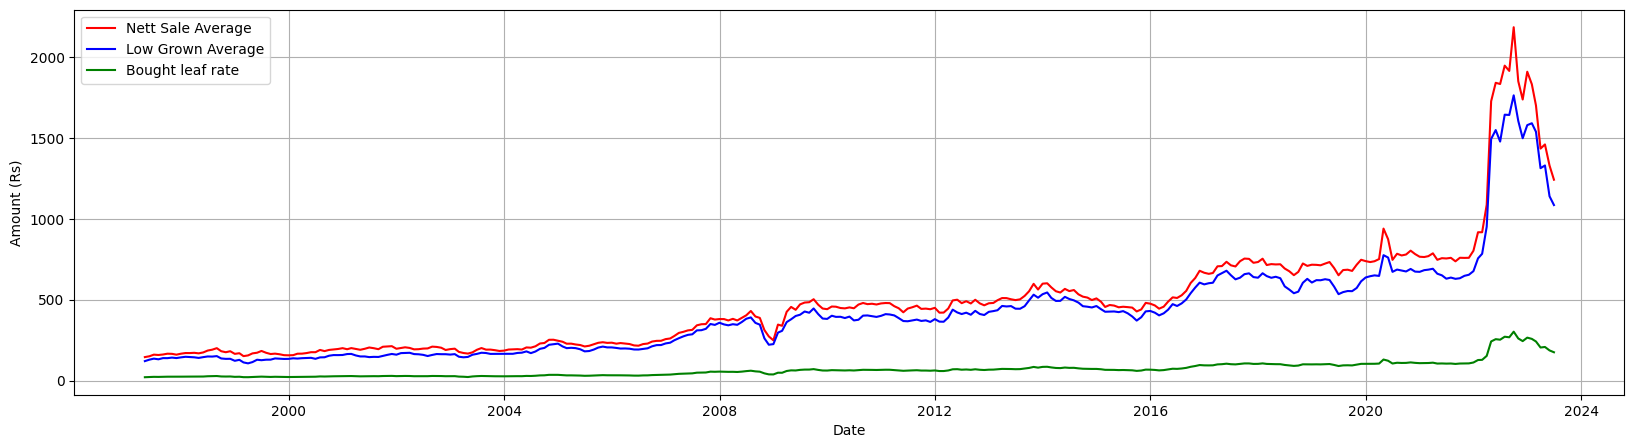

In [32]:
# plotting Nett Sale Average , Low grown average and Price paid per kg for externally purchased green leaf over time

plt.figure(figsize=(20,5))
plt.plot(df['NETT SALE AVERAGE (Rs)'],label = 'Nett Sale Average', color = 'red')
plt.plot(df['LOW GROWN AVERAGE (Rs)'],label = 'Low Grown Average', color = 'blue')
plt.plot(df['BOUGHT LEAF RATE (Rs)'],label = 'Bought leaf rate', color = 'green')
plt.xlabel('Date')
plt.ylabel('Amount (Rs)')
plt.legend(loc='best')
plt.grid()

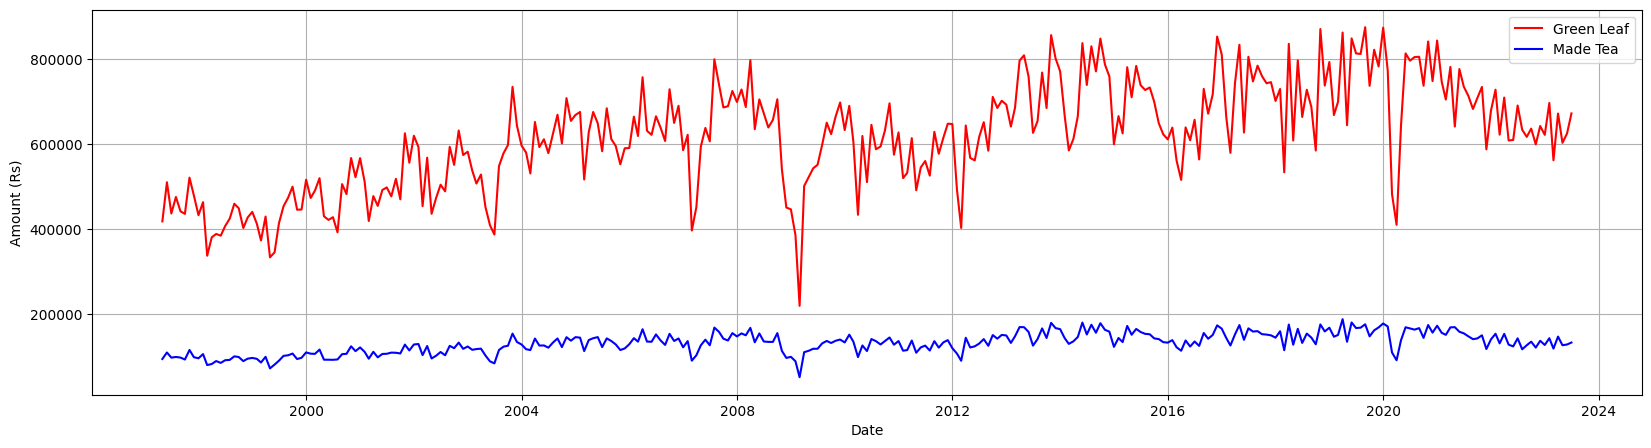

In [29]:
# plotting Green Leaf and Made Tea over time

plt.figure(figsize=(20,5))
plt.plot(df['GREEN LEAF (Kg)'],label = 'Green Leaf', color = 'red')
plt.plot(df['MADE TEA (Kg)'],label = 'Made Tea', color = 'blue')
plt.xlabel('Date')
plt.ylabel('Amount (Rs)')
plt.legend(loc='best')
plt.grid()

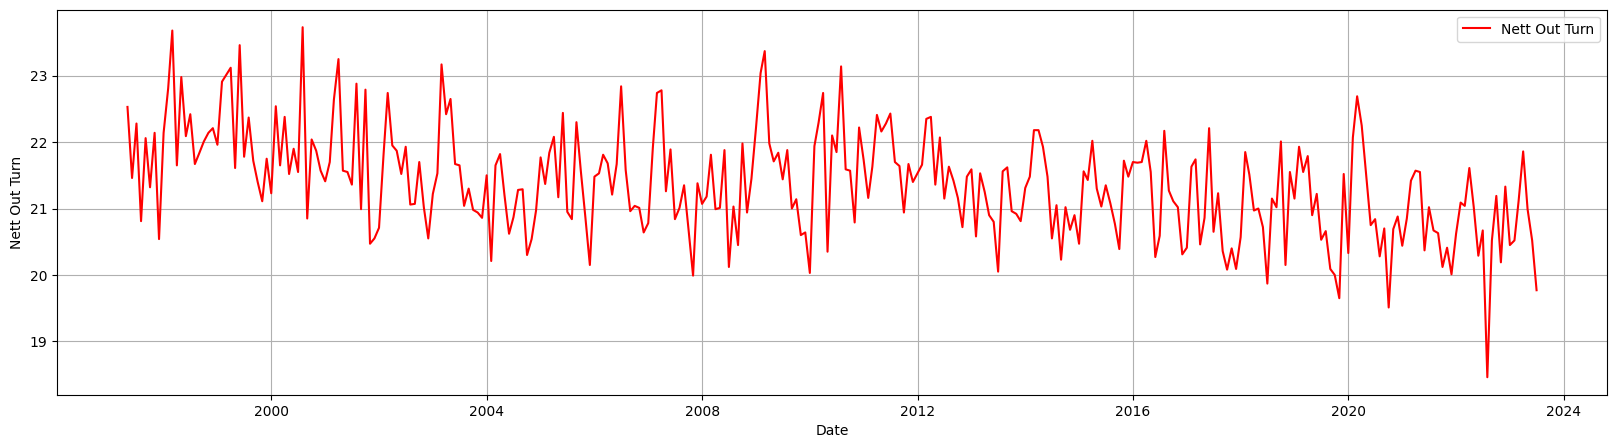

In [30]:
# plotting Nett Out Turn over time

plt.figure(figsize=(20,5))
plt.plot(df['NETT OUT TURN'],label = 'Nett Out Turn', color = 'red')
plt.xlabel('Date')
plt.ylabel('Nett Out Turn')
plt.legend(loc='best')
plt.grid()

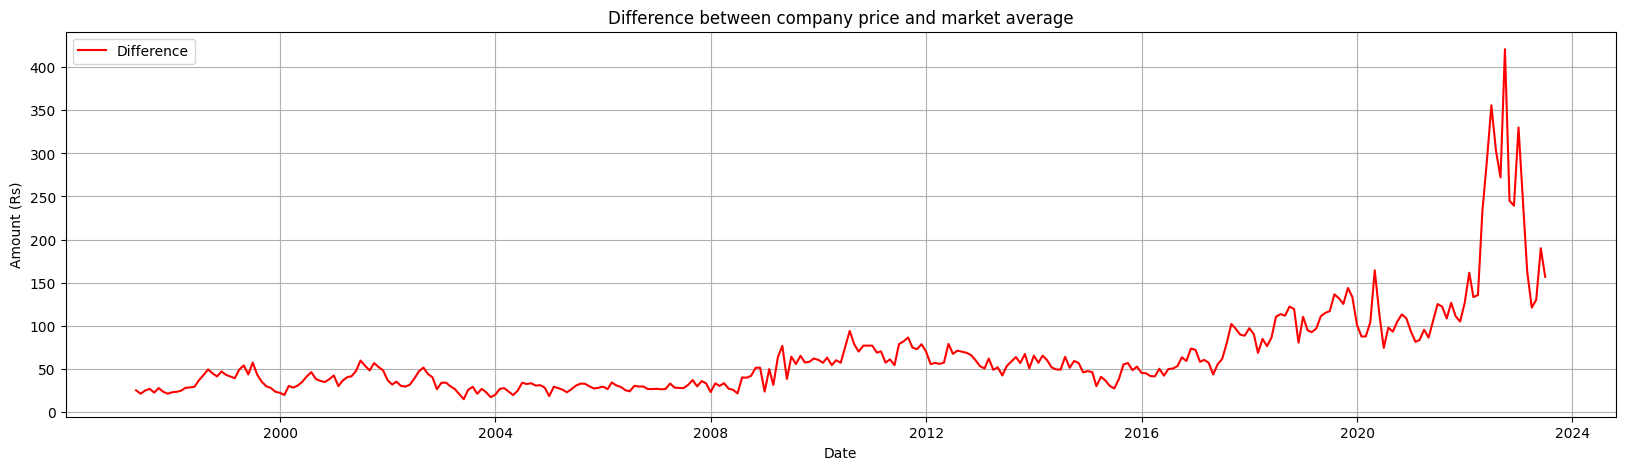

In [31]:
# plotting difference between company price and market average.

plt.figure(figsize=(20,5))
plt.plot(df['DIFFERENCE (Rs)'],label = 'Difference', color = 'red')
plt.xlabel('Date')
plt.ylabel('Amount (Rs)')
plt.title('Difference between company price and market average')
plt.legend(loc='best')
plt.grid()